## Prelude

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.interpolate import UnivariateSpline
import pandas as pd
from pathlib import Path
import pickle

import sys
sys.path.append('../src/')
from imf import IGIMF

In [6]:
DATA_FOLDER = Path('..', 'data')
OSGIMF_FOLDER = Path(DATA_FOLDER, 'OSGIMFs')
GALAXYGRID_PATH = Path('.', 'NB12_GalaxyGrid', 'z0-10-1_5bin_galaxygrid.pkl')

In [7]:
def get_igimf_spline_arrays(mass_array, z, sfr, feh, m_min=None):
    igimf = IGIMF(sfr, feh)
    igimf.get_clusters()
    igimf_array = np.array([igimf.imf(m)[0] for m in mass_array])
    
    spline = UnivariateSpline(mass_array, igimf_array, k=3)
    spline_array = np.array([spline(m) for m in mass_array])
    n_tot = spline.integral(mass_array.min(), mass_array.max())
    if m_min is not None:
        n_massive = spline.integral(m_min, mass_array.max())
       
    try:
        return igimf_array, spline_array, n_tot, n_massive
    except UnboundLocalError:
        return igimf_array, spline_array, n_tot

In [8]:
def plot_count_comparison(ax, mass_array, igimf_array, spline_array, ntot, nmassive, legend=False, fontsize=18, ms=10, lw=2):
    axislabel_fontsize = fontsize
    ticklabel_fontsize = 0.75*fontsize
    legend_fontsize = 0.75*fontsize
    
    
    ax.plot(mass_array, igimf_array, 'r.', markersize=ms, label='IGIMF')
    ax.plot(mass_array, spline_array, 'b-', lw=lw, label='Spline')

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim(1, 2e9)

    ax.set_xlabel(r'$\log\left(M_\ast/\mathrm{M}_\odot\right)$', fontsize=axislabel_fontsize)
    ax.set_ylabel(r'$\log\left(\mathrm{d}N/\mathrm{d}M_\ast\,\left[\mathrm{M}_\odot^{-1}\right]\right)$', fontsize=axislabel_fontsize)
    ax.set_xticks([10.**x for x in np.arange(-1, 3, 1)])
    ax.set_xticklabels([x for x in np.arange(-1, 3, 1)])
    ax.set_xticks([], minor=True)
    ax.set_yticks([10.**x for x in np.arange(0, 10, 2)])
    ax.set_yticklabels([x for x in np.arange(0, 10, 2)])
    ax.tick_params(axis='both', direction='in', labelsize=ticklabel_fontsize)

    if legend:
        ax.legend(loc='upper right', frameon=False, fontsize=legend_fontsize)

    descr = '\n'.join([f'$N_\mathrm{{tot}}={{{ntot:.2e}}}$', f'$N_{{>5\mathrm{{M}}_\odot}}={{{nmassive:.2e}}}$'])
    ax.text(0.1, 0.1, descr, transform=ax.transAxes, fontsize=legend_fontsize)

## Estimating sample size

In [9]:
mass_n = 100
mass_array = np.logspace(np.log10(0.08), np.log10(150), mass_n)

#### Simple example

In [10]:
test1_feh = 0.54
test1_z = 2.01
test1_sfr = 10**1.79

In [11]:
test1_igimf_array, test1_spline_array, test1_ntot, test1_nmassive = get_igimf_spline_arrays(mass_array, test1_z, test1_sfr, test1_feh, 5)

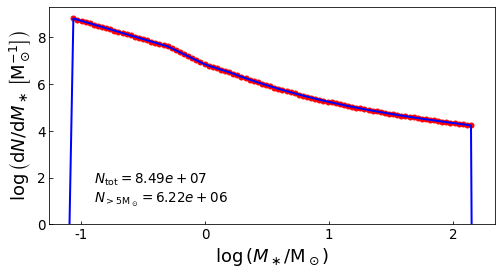

In [13]:
test1_fig, test1_ax = plt.subplots(figsize=(8,4))
plot_count_comparison(test1_ax, mass_array, test1_igimf_array, test1_spline_array, test1_ntot, test1_nmassive)

#### For a sample grid    

In [14]:
grid_df = pd.read_pickle(GALAXYGRID_PATH)
grid_df.describe()

,Redshift,Log(Mgal/Msun),Log(Number density [Mpc-3 Msun-1]),SFR [Msun yr-1],12+log(O/H),[Fe/H]
count,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000
mean,4.286596,9.818747,-3.548812,0.883369,7.857817,-1.305666
std,2.841479,1.004515,1.084744,0.697127,0.841477,1.063419
min,0.010000,7.704408,-5.769317,-1.176931,6.360200,-2.969800
25%,2.010000,9.447604,-4.404656,0.643542,7.160950,-2.169050
50%,4.010000,9.947751,-3.416180,1.094579,7.827456,-1.502544
75%,6.510000,10.433860,-2.736544,1.376474,8.673295,-0.313409
max,9.010000,11.123955,-1.501990,1.760191,9.047231,0.434461


In [15]:
igimfs_array = np.empty((len(grid_df), mass_array.shape[0]), np.float64)
splines_array = np.empty((len(grid_df), mass_array.shape[0]), np.float64)
ntots_array = np.empty(len(grid_df), np.float64)
nmassives_array = np.empty(len(grid_df), np.float64)

In [16]:
for i, (redshift, logsfr, feh) in enumerate(grid_df[['Redshift', 'SFR [Msun yr-1]', '[Fe/H]']].to_numpy()):
    print(f'Integrating IGIMF for z={redshift}, logsfr={logsfr}, feh={feh}')
    igimf, spline, ntot, nmassive = get_igimf_spline_arrays(mass_array, redshift, 10**logsfr, feh, m_min=5)
    igimfs_array[i] = igimf
    splines_array[i] = spline
    ntots_array[i] = ntot
    nmassives_array[i] = nmassive

Integrating IGIMF for z=0.01, logsfr=0.23967009423735042, feh=0.43446148718948896
Integrating IGIMF for z=0.01, logsfr=0.11716552326706689, feh=0.39464186757052566
Integrating IGIMF for z=0.01, logsfr=0.006150529651816616, feh=0.3390338975242604
Integrating IGIMF for z=0.01, logsfr=-0.1383029945731465, feh=0.22467984427613796
Integrating IGIMF for z=0.01, logsfr=-1.176931004654573, feh=-1.1755409850014686
Integrating IGIMF for z=1.01, logsfr=1.094578694279519, feh=0.37746685519084044
Integrating IGIMF for z=1.01, logsfr=0.9129673568708438, feh=0.2879193790394914
Integrating IGIMF for z=1.01, logsfr=0.7494524592510918, feh=0.1767096332121052
Integrating IGIMF for z=1.01, logsfr=0.5376322262547397, feh=-0.02115703998054075
Integrating IGIMF for z=1.01, logsfr=-0.6040494314387871, feh=-1.4132642219218603
Integrating IGIMF for z=2.01, logsfr=1.5795885167850159, feh=0.1793308363036492
Integrating IGIMF for z=2.01, logsfr=1.3695088966404791, feh=0.047131364886847216
Integrating IGIMF for z=2

/home/lucasmdesa/git_repos/environIMF/notebooks/../src/imf.py:629: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  imf = quad(self._integrand, self.m_ecl_min, self.m_ecl_max, args=m)


Integrating IGIMF for z=3.01, logsfr=0.8258736930205788, feh=-1.122618731027245
Integrating IGIMF for z=3.01, logsfr=-0.231745886386031, feh=-2.1828957615708493
Integrating IGIMF for z=4.01, logsfr=1.7458904327175282, feh=-0.8595797257972555
Integrating IGIMF for z=4.01, logsfr=1.3834399934538006, feh=-1.079527955140245
Integrating IGIMF for z=4.01, logsfr=1.0700523192599416, feh=-1.2703141494719663
Integrating IGIMF for z=4.01, logsfr=0.7526894629242831, feh=-1.5161576990500003
Integrating IGIMF for z=4.01, logsfr=-0.16170121489389708, feh=-2.452508455578579
Integrating IGIMF for z=5.01, logsfr=1.7601908385741356, feh=-1.2104425409324937
Integrating IGIMF for z=5.01, logsfr=1.412396879785951, feh=-1.3623407864657329
Integrating IGIMF for z=5.01, logsfr=1.1531070989294392, feh=-1.5211734520454279
Integrating IGIMF for z=5.01, logsfr=0.8836759220982606, feh=-1.7251811240427406
Integrating IGIMF for z=5.01, logsfr=-0.07537508091071904, feh=-2.7016755745289895


/home/lucasmdesa/anaconda3/envs/BCOClass_Py310/lib/python3.8/site-packages/scipy/interpolate/fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


Integrating IGIMF for z=6.01, logsfr=1.7361650434662481, feh=-1.5025444610384362
Integrating IGIMF for z=6.01, logsfr=1.3954411916519711, feh=-1.666587193719316
Integrating IGIMF for z=6.01, logsfr=1.1596995339812142, feh=-1.8202692168525432
Integrating IGIMF for z=6.01, logsfr=0.8994640405749698, feh=-2.024584419172683
Integrating IGIMF for z=6.01, logsfr=-0.012516990858918747, feh=-2.969800129336944
Integrating IGIMF for z=7.01, logsfr=1.5552628793332937, feh=-1.8698801975797166
Integrating IGIMF for z=7.01, logsfr=1.315544178116445, feh=-2.0119772971987127
Integrating IGIMF for z=7.01, logsfr=1.1332394569964386, feh=-2.143153231201153
Integrating IGIMF for z=7.01, logsfr=0.8835962227820171, feh=-2.3509471581691477
Integrating IGIMF for z=8.01, logsfr=1.5620786012061965, feh=-2.1552049366465065


/home/lucasmdesa/git_repos/environIMF/notebooks/../src/imf.py:629: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  imf = quad(self._integrand, self.m_ecl_min, self.m_ecl_max, args=m)


Integrating IGIMF for z=8.01, logsfr=1.3294102007618864, feh=-2.3000458218342965
Integrating IGIMF for z=8.01, logsfr=1.1567352062223168, feh=-2.4286546197818977
Integrating IGIMF for z=8.01, logsfr=0.9123573733262293, feh=-2.6384867666596588
Integrating IGIMF for z=9.01, logsfr=1.5888764258748007, feh=-2.43045904262734
Integrating IGIMF for z=9.01, logsfr=1.3638106152451253, feh=-2.574646294985063
Integrating IGIMF for z=9.01, logsfr=1.1967787676743549, feh=-2.7019426038443486
Integrating IGIMF for z=9.01, logsfr=0.9566078522741935, feh=-2.912790889920813


In [28]:
plot_redshifts = grid_df['Redshift'].to_numpy()#, 10.01)
plot_logsfrs = grid_df['SFR [Msun yr-1]'].to_numpy() #, -6)
plot_fehs = grid_df['[Fe/H]'].to_numpy() #, -6)

redshift_axis, feh_n = np.unique(plot_redshifts, return_counts=True)
redshift_n = redshift_axis.shape[0]

i = 0
j = 0
feh_axis = list()
logsfr_axis = list()
feh_list = list()
sfr_list = list()
for feh, sfr in zip(plot_fehs, plot_logsfrs):
    feh_len = feh_n[j]
    if i < feh_len:
        feh_list.append(feh)
        sfr_list.append(sfr)
        i += 1
    else:
        feh_axis.append(feh_list)
        logsfr_axis.append(sfr_list)
        feh_list = list()
        sfr_list = list()
        j += 1
        i = 0
    

grid = np.array([[z, (logsfr, feh)] for z, logsfr, feh in zip(plot_redshifts, plot_logsfrs, plot_fehs)], dtype=object)
#fmt_grid = np.empty((feh_n, redshift_n), np.float64)

In [52]:
igimfs_list = list()
splines_list = list()
ntots_list = list()
nmassives_list = list()

i = 0
j = 0
igimf_part_array = np.empty((0,100), np.float64)
spline_part_array = np.empty((0,100), np.float64)
ntot_part_array = np.empty(0, np.float64)
nmassive_part_array = np.empty(0, np.float64)
for igimf, spline, ntot, nmassive in zip(igimfs_array, splines_array, ntots_array, nmassives_array):
    row_len = feh_n[j]
    if i < row_len:
        igimf_part_array = np.append(igimf_part_array, igimf.reshape(1,100), axis=0)
        spline_part_array = np.append(spline_part_array, spline.reshape(1,100), axis=0)
        ntot_part_array = np.append(ntot_part_array, ntot)
        nmassive_part_array = np.append(nmassive_part_array, nmassive)
        i += 1
    else:
        igimfs_list.append(igimf_part_array)
        splines_list.append(spline_part_array)
        ntots_list.append(ntot_part_array)
        nmassives_list.append(nmassive_part_array)
        igimf_part_array = np.empty((0,100), np.float64)
        spline_part_array = np.empty((0,100), np.float64)
        ntot_part_array = np.empty((0,100), np.float64)
        nmassive_part_array = np.empty((0,100), np.float64)
        i = 0
        j += 1

In [ ]:
fig, axes = plt.subplots(redshift_n, max(feh_n), figsize=(20,16), sharex='col', sharey='row', tight_layout=True)

for yi, redshift in enumerate(redshift_axis):
    for xi, (feh, logsfr) in enumerate(zip(feh_axis[yi], logsfr_axis[yi])):
        ax = axes[yi, xi]
        igimf = igimfs_list[yi][xi]
        spline = splines_list[yi][xi]
        ntot = ntots_list[yi][xi]
        nmassive = nmassives_list[yi][xi]
        
        plot_count_comparison(ax, mass_array, igimf, spline, ntot, nmassive, fontsize=18, ms=10, lw=2.5)

        descr = '\n'.join([f'z={redshift:.2f},', 
                           r'SFR = $10^{%.2f}\,\mathrm{M}_\odot\mathrm{ yr}^{-1}$' % logsfr, 
                           f'[Fe/H] = {feh:.2f}'])
        ax.text(0.47, 0.65, descr, transform=ax.transAxes, fontsize=12)
        
for ax in axes.flatten():
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylabel('')
    ax.set_xlabel('')
    
for ax in axes[:,0]:
    ax.set_yticks([10.**x for x in np.arange(0, 10, 2)])
    ax.set_yticklabels([x for x in np.arange(0, 10, 2)])
    
for ax in axes[-1,:]:
    ax.set_xticks([10.**x for x in np.arange(-1, 3, 1)])
    ax.set_xticklabels([x for x in np.arange(-1, 3, 1)])
    ax.set_xticks([], minor=True)
       
fig.text(-0.03, 0.4, r'$\log\left(\mathrm{d}N/\mathrm{d}M_\ast\,\left[\mathrm{M}_\odot^{-1}\right]\right)$', rotation=90, fontsize=18)
fig.text(0.4, -0.03, r'$\log\left(M_\ast/\mathrm{M}_\odot\right)$', fontsize=18)

IndexError: list index out of range

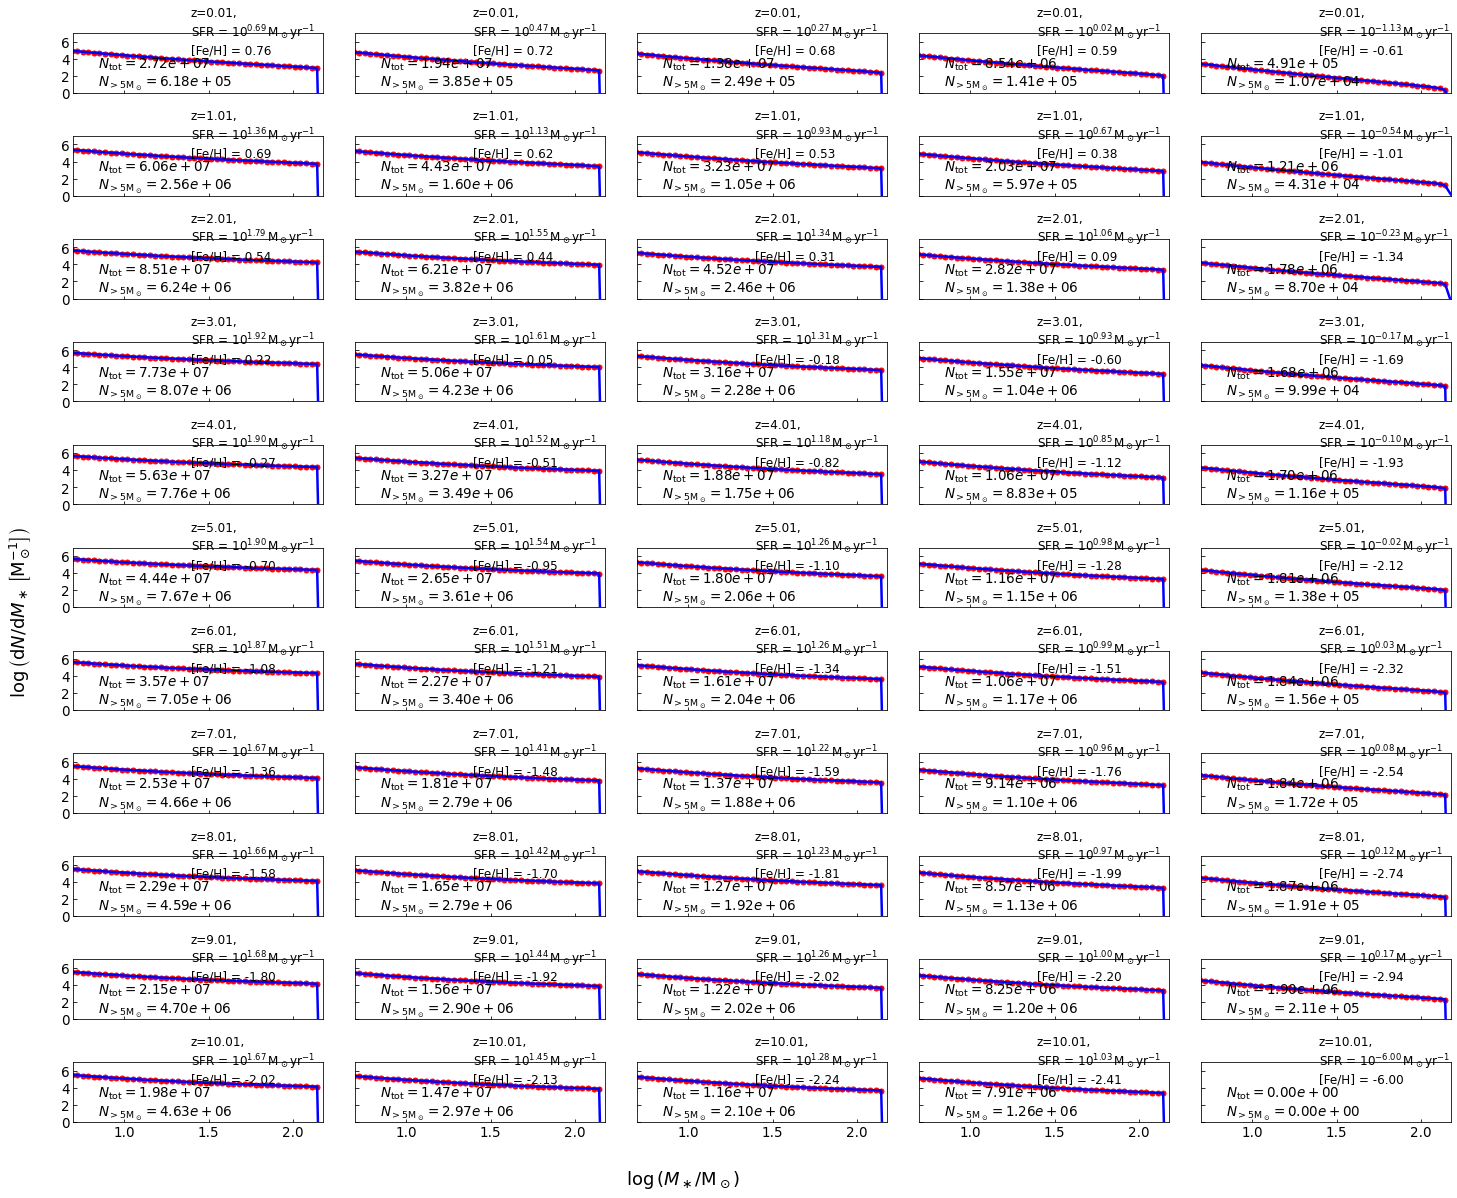

In [272]:
fig, axes = plt.subplots(redshift_n, feh_n, figsize=(20,16), sharex='col', sharey='row', tight_layout=True)

for yi, redshift in enumerate(redshift_axis):
    for xi, (feh, logsfr) in enumerate(zip(feh_axis[yi], logsfr_axis[yi])):
        ax = axes[yi, xi]
        igimf = igimfs_array[yi, xi]
        spline = splines_array[yi, xi]
        ntot = ntots_array[yi, xi]
        nmassive = nmassives_array[yi, xi]
        
        plot_count_comparison(ax, mass_array, igimf, spline, ntot, nmassive, fontsize=18, ms=10, lw=2.5)

        descr = '\n'.join([f'z={redshift:.2f},', 
                           r'SFR = $10^{%.2f}\,\mathrm{M}_\odot\mathrm{ yr}^{-1}$' % logsfr, 
                           f'[Fe/H] = {feh:.2f}'])
        ax.text(0.47, 0.65, descr, transform=ax.transAxes, fontsize=12)
        
for ax in axes.flatten():
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylabel('')
    ax.set_xlabel('')
    
for ax in axes[:,0]:
    ax.set_yticks([10.**x for x in np.arange(0, 8, 2)])
    ax.set_yticklabels([x for x in np.arange(0, 8, 2)])
    
for ax in axes[-1,:]:
    ax.set_xticks([10.**x for x in np.arange(1, 3, 0.5)])
    ax.set_xticklabels([x for x in np.arange(1, 3, 0.5)])
    ax.set_xticks([], minor=True)
       
fig.text(-0.03, 0.4, r'$\log\left(\mathrm{d}N/\mathrm{d}M_\ast\,\left[\mathrm{M}_\odot^{-1}\right]\right)$', rotation=90, fontsize=18)
fig.text(0.4, -0.03, r'$\log\left(M_\ast/\mathrm{M}_\odot\right)$', fontsize=18)

for ax in axes.flatten():
    ax.set_xlim(5, 150)
    ax.set_ylim(1, 1e7)

In [273]:
ratio_array = np.empty(nmassives_array.shape, np.float64)

for i, (ntot_row, nmassive_row) in enumerate(zip(ntots_array, nmassives_array)):
    for j, (ntot, nmassive) in enumerate(zip(ntot_row, nmassive_row)):
        ratio_array[i,j] = nmassive/ntot

C:\Users\Lucas\.conda\envs\BCOClass_Py310\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


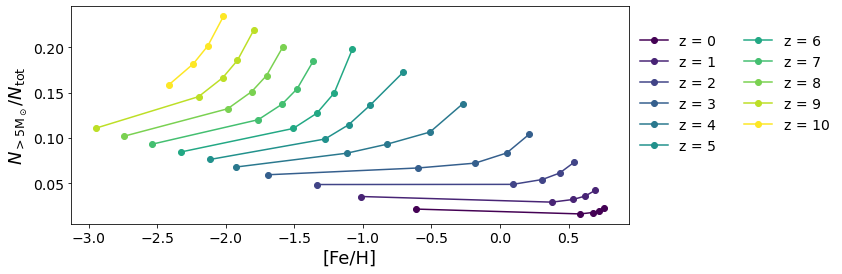

In [304]:
fig, ax = plt.subplots(figsize=(10,4))
redshift_cnorm = redshift_axis.max() - redshift_axis.min()

for redshift, fehs, ratios in zip(redshift_axis, feh_axis, ratio_array):
    color = cm.viridis((redshift-redshift_axis.min())/redshift_cnorm)
    ax.plot(fehs, ratios, linestyle='-', marker='.',  markersize=12, c=color, label=f'z = {redshift:.0f}')

ax.set_xlabel('[Fe/H]', fontsize=18)
ax.set_ylabel(r'$N_{>5\mathrm{M}_\odot}/N_\mathrm{tot}$', fontsize=18)
ax.tick_params(axis='both', labelsize=14)
    
ax.legend(loc=(1.01, 0.3), frameon=False, fontsize=14, ncol=2)

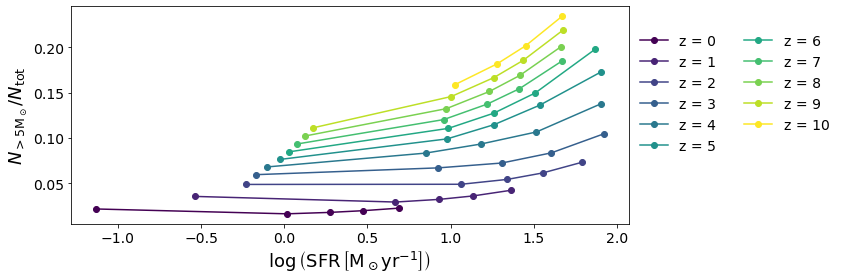

In [306]:
fig, ax = plt.subplots(figsize=(10,4))
redshift_cnorm = redshift_axis.max() - redshift_axis.min()

for redshift, logsfrs, ratios in zip(redshift_axis, logsfr_axis, ratio_array):
    color = cm.viridis((redshift-redshift_axis.min())/redshift_cnorm)
    ax.plot(logsfrs, ratios, linestyle='-', marker='.',  markersize=12, c=color, label=f'z = {redshift:.0f}')

ax.set_xlabel(r'$\log\left(\mathrm{SFR}\,\left[\mathrm{M}_\odot\mathrm{ yr}^{-1}\right]\right)$', fontsize=18)
ax.set_ylabel(r'$N_{>5\mathrm{M}_\odot}/N_\mathrm{tot}$', fontsize=18)
ax.tick_params(axis='both', labelsize=14)
    
ax.legend(loc=(1.01, 0.3), frameon=False, fontsize=14, ncol=2)

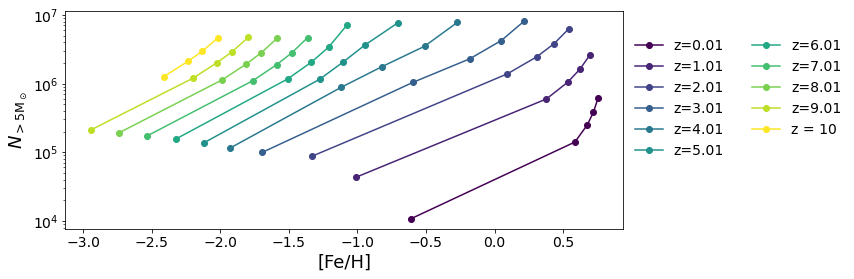

In [309]:
fig, ax = plt.subplots(figsize=(10,4))
redshift_cnorm = redshift_axis.max() - redshift_axis.min()

for redshift, fehs, nmassives in zip(redshift_axis, feh_axis, nmassives_array):
    color = cm.viridis((redshift-redshift_axis.min())/redshift_cnorm)
    if redshift != 10.01:
        ax.plot(fehs, nmassives, linestyle='-', marker='.',  markersize=12, c=color, label=f'z={redshift}')
    else:
        ax.plot(fehs[:-1], nmassives[:-1], linestyle='-', marker='.',  markersize=12, c=color, label=f'z = {redshift:.0f}')

ax.set_yscale('log')
    
ax.set_xlabel('[Fe/H]', fontsize=18)
ax.set_ylabel(r'$N_{>5\mathrm{M}_\odot}$', fontsize=18)
ax.tick_params(axis='both', labelsize=14)
    
ax.legend(loc=(1.01, 0.3), frameon=False, fontsize=14, ncol=2)